In [ ]:
%pip install selenium beautifulsoup4 nltk matplotlib wordcloud selenium validators

In [ ]:
import re
import json
import nltk
import time
import datetime
import random
import validators
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from concurrent.futures import ThreadPoolExecutor, as_completed

# Ensure NLTK data path
nltk.data.path.append('./nltk_data')

# Download necessary NLTK data if not already available
nltk.download('stopwords', download_dir='./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')

STOPWORDS = set(stopwords.words('english')).union({
    "new", "says", "world", "week", "first", "market", "day", "year", "latest", "best", "today", 
    "next", "live", "say", "years", "watch", "breaking", "art", "report", "get", "via", "heres",
    "one","press", "article", "story", "news", "post", "now", "will", "also", "just", "like", 
    "even", "back", "going", "still", "time", "know", "think", "see", "may", "top", "off", 
    "time", "dont", "please", "help", "thank", "about", "before", "youre", "would", "way"
})


PUNCTUATION = set(['.', ',', '!', '?', ':', ';', '-', '’', '“', '”', '…'])

print("First 10 stopwords:", stopwords.words('english')[:10])

First 10 stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Define categories and associated URLs
CATEGORIES = {
    "World": [
        "https://x.com/CNN", 
        "https://x.com/Reuters", "https://x.com/BBCWorld",
        "https://x.com/NBCNews", "https://x.com/NYTimesWorld", "https://x.com/AFP", 
        "https://x.com/guardian", "https://x.com/abcnews", "https://x.com/CTVNews", "https://x.com/NewsHour",
        "https://x.com/globaltimesnews", "https://x.com/RT_com", "https://x.com/europarl_EN", 
        "https://x.com/BreakingNews", "https://x.com/SkyNews",
        "https://x.com/thedailybeast", "https://x.com/time"
    ],
    "Business": [
        "https://x.com/WSJ", 
        "https://x.com/federalreserve", "https://x.com/Business", 
        "https://x.com/FinancialTimes", "https://x.com/CNBC", "https://x.com/Bloomberg", 
        "https://x.com/businessinsider", "https://x.com/MarketWatch", "https://x.com/economics",
        "https://x.com/forbes", "https://x.com/TheEconomist", "https://x.com/YahooFinance",
        "https://x.com/smallbiztrends", "https://x.com/NASDAQ", "https://x.com/SPGlobal",
        "https://x.com/SchwabResearch", "https://x.com/WSJMarkets", "https://x.com/morningstarinc",
        "https://x.com/IBDinvestors"
    ],
    "Music": [
        "https://x.com/billboard", "https://x.com/rollingstone", "https://x.com/NME", "https://x.com/pitchfork",
        "https://x.com/MusicWeek", "https://x.com/ComplexMusic", "https://x.com/MTV",
        "https://x.com/BBCR1", "https://x.com/BET", "https://x.com/AppleMusic",
        "https://x.com/rapradar", "https://x.com/soundcloud", 
        "https://x.com/popjustice", "https://x.com/AltPress", "https://x.com/classicfm",
        "https://x.com/HotNewHipHop", "https://x.com/SONGKICK", "https://x.com/officialcharts"
    ],
    "Technology": [
        "https://x.com/verge", "https://x.com/wired", "https://x.com/TechCrunch", "https://x.com/gizmodo",
        "https://x.com/engadget", "https://x.com/CNET", "https://x.com/zdnet", "https://x.com/arstechnica",
        "https://x.com/mashable", "https://x.com/digitaltrends", "https://x.com/recode",
        "https://x.com/VentureBeat", "https://x.com/thenextweb", "https://x.com/slashdot",
        "https://x.com/macrumors", "https://x.com/androidcentral",
        "https://x.com/9to5mac", "https://x.com/PCMag"
    ],
    "Games": [
        "https://x.com/IGN", "https://x.com/GameSpot", "https://x.com/Kotaku",
        "https://x.com/TheVerge", "https://x.com/Polygon", "https://x.com/GamesRadar", "https://x.com/PCGamer",
        "https://x.com/Shacknews", "https://x.com/Destructoid",
        "https://x.com/PlayStation", "https://x.com/Xbox", "https://x.com/Nintendo", "https://x.com/Steam",
        "https://x.com/Blizzard_Ent"
    ],
}

In [ ]:

def init_driver(headless=True):
    options = Options()
    if headless:
        options.add_argument("--headless")
        options.add_argument("--disable-gpu")
        options.add_argument("--no-sandbox")
    return webdriver.Chrome(options=options)

import validators

def scroll_and_scrape(driver, max_scrolls=10):
    tweets = []
    seen_texts = set()

    for _ in range(max_scrolls):
        driver.execute_script("window.scrollBy(0, 300);")
        time.sleep(1)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        for tweet_div in soup.find_all('article'):
            tweet_text_tag = tweet_div.find(['div', 'span'], {'data-testid': 'tweetText'})
            time_tag = tweet_div.find('time')

            tweet_text = tweet_text_tag.get_text(separator=" ", strip=True) if tweet_text_tag else None
            tweet_timestamp = time_tag['datetime'] if time_tag else None

            # Validate tweet content and timestamp
            if tweet_text and tweet_timestamp:
                # Check if URLs are valid
                urls = re.findall(r'http[s]?://\S+', tweet_text)
                valid_urls = [url for url in urls if validators.url(url)]

                # If content is not empty and URLs are valid, add the tweet
                if tweet_text not in seen_texts and (not urls or valid_urls):
                    tweets.append({
                        "text": tweet_text,
                        "timestamp": tweet_timestamp
                    })
                    seen_texts.add(tweet_text)

    return tweets


def scrape_account(url, headless=True, max_retries=5):
    driver = init_driver(headless)
    driver.get(url)

    tweets = []
    retries = 0

    while retries < max_retries and not tweets:
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, "//div[@data-testid='tweetText']"))
            )
            tweets = scroll_and_scrape(driver)  # No changes needed here, returns text + timestamp
        except Exception as e:
            retries += 1
            time.sleep(2)

    driver.quit()
    if tweets:
        print(f"Collected {len(tweets)} tweets from {url}.")
    else:
        print(f"Failed to collect tweets from {url} after {max_retries} retries.")
    return tweets



def scrape_multiple_accounts(urls, headless=True, max_retries=8):
    unique_urls = list(set(urls))  # Remove duplicate URLs if any
    all_tweets = []  # Use a list to store tweets

    with ThreadPoolExecutor(max_workers=20) as executor:
        future_to_url = {executor.submit(scrape_account, url, headless, max_retries): url for url in unique_urls}

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                tweets = future.result()
                all_tweets.extend(tweets)  # Append tweets (dictionaries) to the list
            except Exception as exc:
                print(f"Exception occurred while scraping {url}: {exc}")

    # Deduplicate tweets based on their text content
    unique_tweets = {tweet['text']: tweet for tweet in all_tweets}.values()
    return list(unique_tweets)  # Convert back to list for final output


In [50]:
def select_category():
    print("Available categories:")
    for i, category in enumerate(CATEGORIES, 1):
        print(f"{i}. {category}")

    # Prompt user for multiple category numbers, separated by commas
    choice = input("Select categories by number, 1. World 2. Business 3. Music 4. Technology 5. Games")

    # Split the input and convert to integers, then adjust for zero-based index
    selected_indices = [int(x.strip()) - 1 for x in choice.split(",")]

    # Get the corresponding category names
    selected_categories = [list(CATEGORIES.keys())[i] for i in selected_indices]

    # Get the URLs for the selected categories
    selected_urls = []
    for category in selected_categories:
        selected_urls.extend(CATEGORIES[category])

    return selected_categories, selected_urls

In [51]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    words = text.lower().split()
    return [word for word in words if word not in STOPWORDS and word not in PUNCTUATION]

In [52]:
if __name__ == "__main__":
    # Select categories and URLs
    category, urls = select_category()
    print(f"Scraping tweets for category: {category}")

    # Scrape multiple accounts concurrently
    all_tweets = scrape_multiple_accounts(urls, headless=True)
    print(f"\nTotal unique tweets collected: {len(all_tweets)}\n")

    # Get the current time and format it for the filename (e.g., '2024-11-15_13-45-30')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    
    # Create a filename using the category and timestamp (e.g., 'World_2024-11-15_13-45-30.json')
    json_filename = f"./data/{category}_{timestamp}.json"

    # Save unique tweets to the JSON file with the category and timestamped filename
    with open(json_filename, "w", encoding="utf-8") as file:
        json.dump(all_tweets, file, ensure_ascii=False, indent=2)  # Use `all_tweets` here

    print(f"All unique tweets for category '{category}' have been saved to {json_filename}")


Available categories:
1. World
2. Business
3. Music
4. Technology
5. Games
Scraping tweets for category: ['World', 'Business', 'Music', 'Technology', 'Games']
Collected 13 tweets from https://x.com/guardian.
Collected 10 tweets from https://x.com/RT_com.
Collected 15 tweets from https://x.com/rapradar.
Collected 12 tweets from https://x.com/NME.
Collected 9 tweets from https://x.com/HotNewHipHop.Collected 14 tweets from https://x.com/wired.

Collected 14 tweets from https://x.com/GamesRadar.
Collected 13 tweets from https://x.com/GameSpot.
Collected 10 tweets from https://x.com/Xbox.
Collected 13 tweets from https://x.com/Shacknews.
Collected 13 tweets from https://x.com/CNBC.
Collected 13 tweets from https://x.com/recode.
Collected 13 tweets from https://x.com/Nintendo.
Collected 11 tweets from https://x.com/businessinsider.
Collected 21 tweets from https://x.com/slashdot.
Collected 12 tweets from https://x.com/time.
Collected 12 tweets from https://x.com/forbes.
Collected 11 tweets f

Total tweets within the last month: 573


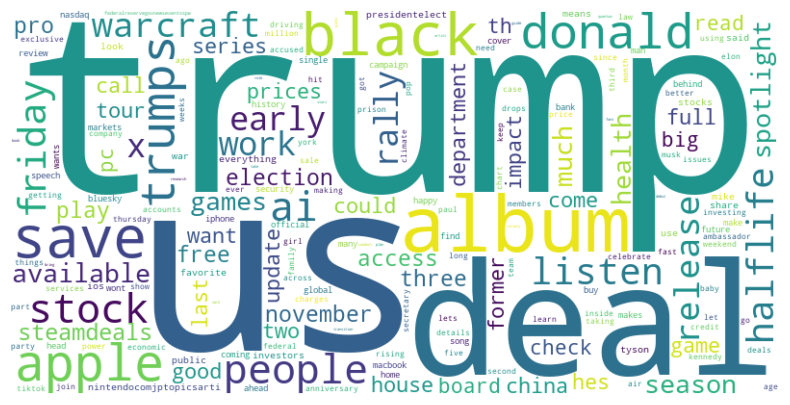

In [53]:
from datetime import datetime, timedelta

# Define the time range (one month ago)
one_month_ago = datetime.now() - timedelta(days=30)

# Define the timestamp format in your data
timestamp_format = "%Y-%m-%dT%H:%M:%S.%fZ"  # Matches '2024-11-03T02:42:07.000Z'

# Filter tweets within the latest one month
recent_tweets = []
for tweet in all_tweets:
    if tweet['timestamp'] != 'No Timestamp Found':
        try:
            tweet_time = datetime.strptime(tweet['timestamp'], timestamp_format)  # Parse the timestamp
            if tweet_time > one_month_ago:  # Compare with one month ago
                recent_tweets.append(tweet)
        except ValueError:
            print(f"Invalid timestamp format for tweet: {tweet['timestamp']}")

print(f"Total tweets within the last month: {len(recent_tweets)}")

# Proceed with preprocessing only the recent tweets
processed_tweets = []
for tweet in recent_tweets:
    words = preprocess_text(tweet['text'])  # Use 'text' from the tweet dictionary
    filtered_words = [word for word in words if word not in STOPWORDS]
    processed_tweets.append(filtered_words)

# Generate a combined text string from all recent tweets
all_text = " ".join([" ".join(tweet) for tweet in processed_tweets])  # Join processed words
word_freq = Counter(all_text.split())  # Count the frequency of each word

# Generate and save the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
wordcloud_filename = f"./image/{category}_{timestamp}_wordcloud.png"
wordcloud.to_file(wordcloud_filename)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Top Keywords: [('trump', 31), ('us', 29), ('deal', 18), ('album', 17), ('black', 17), ('save', 16), ('apple', 16), ('trumps', 15), ('donald', 15), ('people', 14)]
Top keywords saved to: ./data/['World', 'Business', 'Music', 'Technology', 'Games']_2024-11-17_03-58_top_keywords.csv


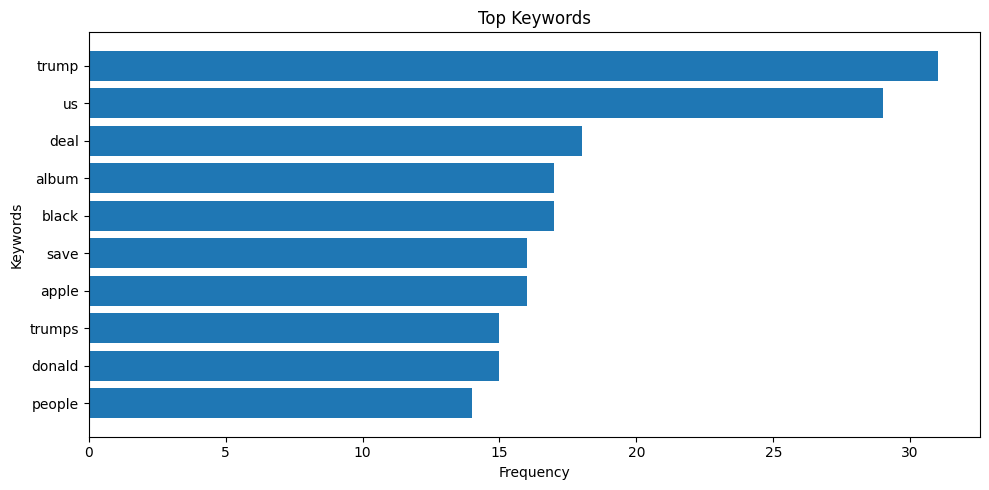

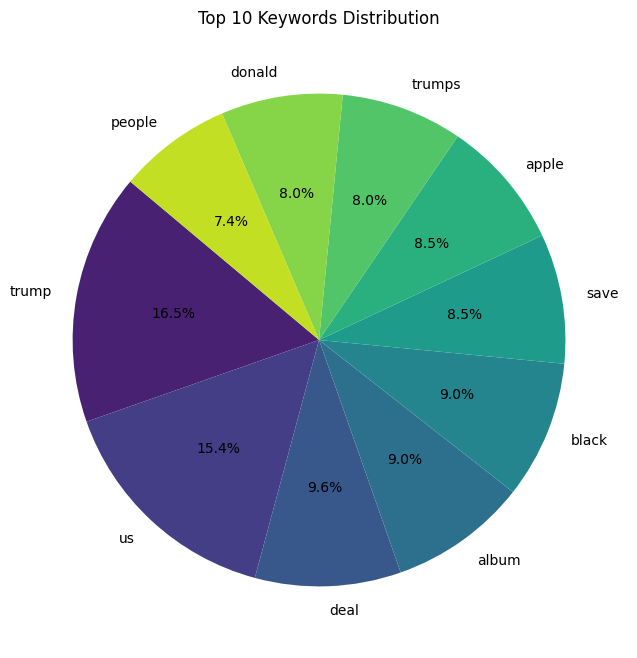

Bar plot saved to: ./image/['World', 'Business', 'Music', 'Technology', 'Games']_2024-11-17_03-58_barplot.png
Pie chart saved to: ./image/['World', 'Business', 'Music', 'Technology', 'Games']_2024-11-17_03-58_piechart.png


In [54]:
# Extract keywords (top_n most common words)
def extract_keywords(texts, top_n):
    all_words = []
    for text in texts:
        all_words.extend(text)  # Flatten the list of lists
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Extract top 10 keywords
keywords = extract_keywords(processed_tweets, top_n=10)
print("Top Keywords:", keywords)

import csv

# File path for saving the top keywords as CSV
csv_file_path = f"./data/{category}_{timestamp}_top_keywords.csv"

# Save the keywords to a CSV file
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Keyword", "Frequency"])  # Write the header
    writer.writerows(keywords)  # Write the keywords and their frequencies

print(f"Top keywords saved to: {csv_file_path}")

# Generate bar plot
def generate_bar_plot(keywords, save_path):
    words, frequencies = zip(*keywords)

    plt.figure(figsize=(10, 5))
    plt.barh(words, frequencies)
    plt.xlabel('Frequency')
    plt.ylabel('Keywords')
    plt.title('Top Keywords')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.tight_layout()
    plt.savefig(save_path)  # Save the bar plot
    plt.show()

# Generate pie chart
def generate_pie_chart(keywords, save_path, top_n=10):
    keywords = sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]
    words, frequencies = zip(*keywords)

    plt.figure(figsize=(10, 8))
    plt.pie(frequencies, labels=words, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(words)))
    plt.title(f'Top {top_n} Keywords Distribution')
    plt.savefig(save_path)  # Save the pie chart
    plt.show()

# File paths for saving the plots
bar_plot_path = f"./image/{category}_{timestamp}_barplot.png"
pie_chart_path = f"./image/{category}_{timestamp}_piechart.png"

# Generate and save the plots
generate_bar_plot(keywords, bar_plot_path)
generate_pie_chart(keywords, pie_chart_path)

print(f"Bar plot saved to: {bar_plot_path}")
print(f"Pie chart saved to: {pie_chart_path}")
